source: https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive/05_artandscience/d_customestimator.ipynb

A few changes have been made to the original source file.


<h1> Time series prediction using RNNs, with TensorFlow and Cloud ML Engine </h1>

This notebook illustrates:
<ol>
<li> Creating a Recurrent Neural Network in TensorFlow
<li> Creating a Custom Estimator in tf.estimator
<li> Training on Cloud ML Engine
</ol>

<p>
    
Here, we are trying to predict from 9 values of a timeseries, the tenth value.    

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [34]:
import numpy as np
import pandas as pd
import shutil

import tensorflow as tf

from google.datalab.ml import TensorBoard

print(tf.__version__)

1.12.0


In [ ]:
%matplotlib inline

import matplotlib
#import numpy as np
import matplotlib.pyplot as plt

In [2]:
SEQ_LEN = 100
def create_time_series():
  freq = (np.random.random() * 0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0, SEQ_LEN) * freq) * ampl
  return x

for plotting refer also to:

https://machinelearningmastery.com/time-series-data-visualization-with-python/



In [31]:
series = create_time_series()

In [36]:
series

array([ 0.        ,  0.74550477,  1.24006525,  1.31720749,  0.95096464,
        0.26461767, -0.51080223, -1.11428103, -1.34268181, -1.11912259,
       -0.51885562,  0.25606329,  0.94478876,  1.31548897,  1.24338257,
        0.75274128,  0.00871982, -0.73823682, -1.23669563, -1.31887045,
       -0.95710041, -0.27316089,  0.50272729,  1.10939248,  1.34262518,
        1.12391694,  0.52688713, -0.24749811, -0.93857303, -1.31371498,
       -1.24664745, -0.75994604, -0.01743927,  0.73093773,  1.23327385,
        1.32047778,  0.96319581,  0.28169259, -0.49463115, -1.10445714,
       -1.34251192, -1.12866389, -0.53489642,  0.23892249,  0.93231772,
        1.31188557,  1.24985975,  0.76711875,  0.02615799, -0.72360781,
       -1.22980006, -1.32202942, -0.96925059, -0.29021241,  0.48651414,
        1.09947522,  1.34234204,  1.13336324,  0.54288315, -0.23033679,
       -0.92602308, -1.31000084, -1.25301933, -0.77425911, -0.0348756 ,
        0.71624738,  1.2262744 ,  1.32352531,  0.97526449,  0.29

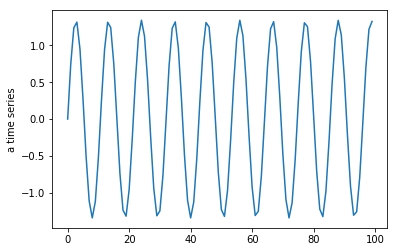

In [47]:
plt.plot(series)
plt.ylabel('a time series')
plt.show()

In [4]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in range(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

In [5]:
to_csv('train.csv', 1000)  # 1000 sequences
to_csv('valid.csv',  100)

In [6]:
!head -2 train.csv valid.csv

==> train.csv <==
0.0,0.19824533877214007,0.38975257129546365,0.5680126109596567,0.726966626345958,0.8612119731804463,0.9661858233230881,1.0383202494773862,1.0751634944891222,1.0754633034453793,1.0392094862220713,0.967634263833265,0.8631703868103244,0.7293684491137615,0.5707762079724771,0.3927840114151631,0.20144158721495062,0.0032524203574257893,-0.19504729212033897,-0.3867175958766132,-0.5652438617178348,-0.7245582095369958,-0.8592457478203014,-0.9647286189042872,-1.037421594519797,-1.0748539331287268,-1.0757533572780438,-1.0400892966879196,-0.969073927296558,-0.8651209709459021,-0.7317636560543739,-0.5735346276887455,-0.3958118887386573,-0.20463600845680135,-0.006504811213368394,0.19184747626782664,0.38367911268773386,0.5624699853612956,0.7221432205327184,0.8572717285647824,0.9632626637946158,1.0365135295006653,1.074534622172108,1.0760336533561459,1.0409596728945014,0.97050480065432,0.8670637078941632,0.7341522254417739,0.5762878450878723,0.3988361758012084,0.20782857352229894,0.009

<h2> RNN </h2>

For more info, see:
<ol>
<li> http://colah.github.io/posts/2015-08-Understanding-LSTMs/ for the theory
<li> https://www.tensorflow.org/tutorials/recurrent for explanations
<li> https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb for sample code
</ol>

Here, we are trying to predict from 9 values of a timeseries, the tenth value.


<h3> Input Fn to read CSV </h3>

Our CSV file structure is quite simple -- a bunch of floating point numbers (note the type of DEFAULTS). 

We ask for the data to be read BATCH_SIZE sequences at a time.  

The Estimator API in tf.contrib.learn wants the features returned as a dict. We'll just call this timeseries column 'rawdata'.

Our CSV file sequences consist of SEQ_LEN numbers. We'll assume that (SEQ_LEN - N_OUTPUTS) of them are inputs and we need to predict the last N_OUTPUTS.

In [7]:
for x in range(0, 5): print(x)

0
1
2
3
4


In [8]:
[[0.0] for x in range(0, 5)]

[[0.0], [0.0], [0.0], [0.0], [0.0]]

In [9]:
# tf.zeros([SEQ_LEN, 1], tf.int32)

DEFAULTS = [[0.0] for x in range(0, SEQ_LEN)]

TIMESERIES_COL = 'rawdata'

# In each sequence, column index (0) to (N_INPUTS - 1) are features, and 
# column index (N_INPUTS) to (SEQ_LEN-1) are labels

# Example, SEQ_LEN=100, N_OUTPUTS=1: In each sequence, 
# column index (0) to (98) are features, and 
# column index (99) to (99) are labels

N_OUTPUTS = 1
N_INPUTS = SEQ_LEN - N_OUTPUTS

BATCH_SIZE = 32

Reading data using the Estimator API in tf.estimator requires an input_fn. This input_fn needs to return a dict of features and the corresponding labels.
<p>
So, we read the CSV file.  The Tensor format here will be a scalar -- entire line.  We then decode the CSV. At this point, all_data will contain a list of scalar Tensors. There will be SEQ_LEN of these tensors.
<p>
We split this list of SEQ_LEN tensors into a list of N_INPUTS Tensors and a list of N_OUTPUTS Tensors. We stack them along the first dimension to then get a vector Tensor for each.  We then put the inputs into a dict and call it features.  The other is the ground truth, so labels.
    
tf.io.decode_csv(): Convert CSV records to tensors. Each column maps to one tensor.

In [10]:
# Read data and convert to needed format
def read_dataset(filename, mode, batch_size = 512):
    
  def _input_fn():
    
    # Provide the ability to decode a CSV
    def decode_csv(line):
        
      # all_data is a list of scalar tensors
      all_data = tf.io.decode_csv(line, record_defaults = DEFAULTS)
      
      inputs = all_data[:len(all_data) - N_OUTPUTS]  # first N_INPUTS values
      labels = all_data[len(all_data) - N_OUTPUTS:] # last N_OUTPUTS values

      # Convert each list of rank R tensors to one rank R+1 tensor
      inputs = tf.stack(inputs, axis = 0)
      labels = tf.stack(labels, axis = 0)
      
      # Convert input R+1 tensor into a feature dictionary of one R+1 tensor
      features = {TIMESERIES_COL: inputs}

      return features, labels

    # Create list of files that match pattern
    file_list = tf.gfile.Glob(filename)

    # Create dataset from file list
    dataset = tf.data.TextLineDataset(file_list).map(decode_csv)

    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # indefinitely
        dataset = dataset.shuffle(buffer_size = 10 * batch_size)
    else:
        num_epochs = 1 # end-of-input after this

    dataset = dataset.repeat(num_epochs).batch(batch_size)

    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

  return _input_fn

<h3> Define RNN </h3>

A recursive neural network consists of possibly stacked LSTM cells.
<p>
The RNN has one output per input, so it will have 8 output cells.  We use only the last output cell, but rather use it directly, we do a matrix multiplication of that cell by a set of weights to get the actual predictions. This allows for a degree of scaling between inputs and predictions if necessary (we don't really need it in this problem).
<p>
Finally, to supply a model function to the Estimator API, you need to return a EstimatorSpec. The rest of the function creates the necessary objects.

### ?

We also get the state at the end of the dynamic run as a return value but we discard it because every time we look at a new sequence, the state becomes irrelevant for us, or?

### 1 x tf.nn.rnn_cell.LSTMCell()

A result: 

global step 1000: global_step = 1000, loss = 0.027975492, rmse = 0.16725875

In [21]:
LSTM_SIZE = 64

# Create the inference model
def custom_estimator(features, labels, mode):
  # 0. Reformat input shape to become a sequence
  x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
    
  # 1. Configure the RNN
  lstm_cell = tf.nn.rnn_cell.LSTMCell(LSTM_SIZE, forget_bias = 1.0)
  outputs, _ = tf.nn.static_rnn(lstm_cell, x, dtype = tf.float32)

  # Slice to keep only the last cell of the RNN
  outputs = outputs[-1]
  
  # Output is result of linear activation of last layer of RNN
  weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
  bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
  predictions = tf.matmul(outputs, weight) + bias
    
  # 2. Loss function, training/eval ops
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.losses.mean_squared_error(labels, predictions)
    train_op = tf.contrib.layers.optimize_loss(
      loss = loss,
      global_step = tf.train.get_global_step(),
      learning_rate = 0.01,
      optimizer = "SGD")
    eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
    }
  else:
    loss = None
    train_op = None
    eval_metric_ops = None
  
  # 3. Create predictions
  predictions_dict = {"predicted": predictions}
  
  # 4. Create export outputs
  export_outputs = {"predict_export_outputs": tf.estimator.export.PredictOutput(outputs = predictions)}
  
  # 5. Return EstimatorSpec
  return tf.estimator.EstimatorSpec(
      mode = mode,
      predictions = predictions_dict,
      loss = loss,
      train_op = train_op,
      eval_metric_ops = eval_metric_ops,
      export_outputs = export_outputs)

### Another

Not ready yet!

In [21]:
LSTM_SIZE = 64

# Create the inference model
def custom_estimator(features, labels, mode):
  # 0. Reformat input shape to become a sequence
  x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
    
  # 1. Configure the RNN
  lstm_cell = tf.nn.rnn_cell.LSTMCell(LSTM_SIZE, forget_bias = 1.0)
  outputs, state = tf.nn.static_rnn(lstm_cell, x, dtype = tf.float32)

  # Slice to keep only the last cell of the RNN
  outputs = outputs[-1]
  
  # Output is result of linear activation of last layer of RNN
  weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
  bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
  predictions = tf.matmul(outputs, weight) + bias
    
  # 2. Loss function, training/eval ops
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.losses.mean_squared_error(labels, predictions)
    train_op = tf.contrib.layers.optimize_loss(
      loss = loss,
      global_step = tf.train.get_global_step(),
      learning_rate = 0.01,
      optimizer = "SGD")
    eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
    }
  else:
    loss = None
    train_op = None
    eval_metric_ops = None
  
  # 3. Create predictions
  predictions_dict = {"predicted": predictions, "state": state}
  
  # 4. Create export outputs
  export_outputs = {"predict_export_outputs": tf.estimator.export.PredictOutput(outputs = predictions)}
  
  # 5. Return EstimatorSpec
  return tf.estimator.EstimatorSpec(
      mode = mode,
      predictions = predictions_dict,
      loss = loss,
      train_op = train_op,
      eval_metric_ops = eval_metric_ops,
      export_outputs = export_outputs)

<h3> Estimator </h3>

Distributed training is launched off using an Estimator.  The key line here is that we use tf.estimator.Estimator rather than, say tf.estimator.DNNRegressor.  This allows us to provide a model_fn, which will be our RNN defined above.  Note also that we specify a serving_input_fn(), this is how we parse the input data provided to us at prediction time.

In [22]:
# Create functions to read in respective datasets
def get_train():
  return read_dataset(filename = 'train.csv', mode = tf.estimator.ModeKeys.TRAIN, batch_size = 512)

def get_valid():
  return read_dataset(filename = 'valid.csv', mode = tf.estimator.ModeKeys.EVAL, batch_size = 512)

In [23]:
# Create serving input function
def serving_input_fn():
    
  feature_placeholders = {
      TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
  }
  
  features = {
    key: tf.expand_dims(tensor, -1)
    for key, tensor in feature_placeholders.items()
  }
  features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis = [2])
    
  return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

In [24]:
# Create custom estimator's train and evaluate function
def train_and_evaluate(output_dir):
    
  estimator = tf.estimator.Estimator(model_fn = custom_estimator, 
                                     model_dir = output_dir)

  train_spec = tf.estimator.TrainSpec(input_fn = get_train(),
                                      max_steps = 1000)
    
  exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)

  eval_spec = tf.estimator.EvalSpec(input_fn = get_valid(),
                                    steps = None,
                                    exporters = exporter)
    
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [28]:
# Launch tensorboard

# Note: If you use jupyter then you may have to use the address shown in the terminal console instead of the below link to tensorboard.

TensorBoard().start('outputdir')

TensorBoard was started successfully with pid 15451. Click here to access it.

15451

In [25]:
# start fresh each time
shutil.rmtree('outputdir', ignore_errors = True) 

# Run the model
train_and_evaluate('outputdir')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f67c0b3ada0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start t

<h3> Standalone Python module </h3>

To train this on Cloud ML Engine, we take the code in this notebook and make a standalone Python module.

If it works with python locally then there is a good chance it will work on the gcloud ml-engine too.

In [48]:
%%bash
echo $PWD

/home/local/git-private/Artificial-Neural-Networks/python/tf.estimator-C


In [50]:
# Launch tensorboard

# Note: If you use jupyter then you may have to use the address shown in the terminal console instead of the below link to tensorboard.

TensorBoard().start('outputdir')

TensorBoard was started successfully with pid 20623. Click here to access it.

20623

In [49]:
%%bash
# Run module as-is
echo $PWD
rm -rf outputdir
export PYTHONPATH=${PYTHONPATH}:${PWD}/simplernn
python -m trainer.task \
  --train_data_paths="${PWD}/train.csv*" \
  --eval_data_paths="${PWD}/valid.csv*"  \
  --output_dir=outputdir \
  --job-dir=./tmp

/home/local/git-private/Artificial-Neural-Networks/python/tf.estimator-C


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa3ffeaea10>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'outputdir/', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:

## gcloud ml engine local predict

Try out online prediction. This is how the REST API will work after you train on Cloud ML Engine.

gcloud ml-engine local predict doesn't work with Python 3 yet.

Run using e.g. Google Cloud Datalab where you can choose between python 2 or 3 in the notebook.

In [13]:
# make a time series of length (SEQ_LEN) and write (N_INPUTS = SEQ_LEN - N_OUTPUTS) of these to test.json

%%writefile test.json
{"rawdata_input": [0,0.214,0.406,0.558,0.655,0.687,0.65,0.549,0.393]}

Writing test.json


In [ ]:
# gcloud ml-engine local predict doesn't work with Python 3 yet.
%%bash
MODEL_DIR=$(ls ./outputdir/export/exporter/)
gcloud ml-engine local predict --model-dir=./outputdir/export/exporter/$MODEL_DIR --json-instances=test.json

<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine.

In [ ]:
import os
PROJECT = 'cloud-training-demos' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'cloud-training-demos-ml' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-central1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
os.environ['TFVERSION'] = '1.8'  # Tensorflow version

In [ ]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

In [ ]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

In [41]:
%%bash
# Run module on Cloud ML Engine
OUTDIR=gs://${BUCKET}/simplernn/model_trained
JOBNAME=simplernn_$(date -u +%y%m%d_%H%M%S)
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/simplernn/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --runtime-version=1.4 \
   -- \
   --train_data_paths="gs://${BUCKET}/train.csv*" \
   --eval_data_paths="gs://${BUCKET}/valid.csv*"  \
   --output_dir=$OUTDIR

jobId: simplernn_180912_200305
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [simplernn_180912_200305] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe simplernn_180912_200305

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs simplernn_180912_200305


<h2> Variant: long sequence </h2>

To create short sequences from a very long sequence.

In [42]:
import tensorflow as tf
import numpy as np

def breakup(sess, x, lookback_len):
  N = sess.run(tf.size(x))
  windows = [tf.slice(x, [b], [lookback_len]) for b in range(0, N-lookback_len)]
  windows = tf.stack(windows)
  return windows

x = tf.constant(np.arange(1,11, dtype=np.float32))
with tf.Session() as sess:
    print('input=', x.eval())
    seqx = breakup(sess, x, 5)
    print('output=', seqx.eval())

input= [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
output= [[1. 2. 3. 4. 5.]
 [2. 3. 4. 5. 6.]
 [3. 4. 5. 6. 7.]
 [4. 5. 6. 7. 8.]
 [5. 6. 7. 8. 9.]]


## Variant: Keras

You can also invoke a Keras model from within the Estimator framework by creating an estimator from the compiled Keras model:

In [43]:
LSTM_SIZE = 64

def make_keras_estimator(output_dir):
  from tensorflow import keras
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(LSTM_SIZE, input_shape=(N_INPUTS,), name=TIMESERIES_INPUT_LAYER))
  model.add(keras.layers.Activation('tanh'))
  model.add(keras.layers.Dense(1))
  model.compile(loss = 'mean_squared_error',
                optimizer = 'adam',
                metrics = ['mae', 'mape']) # mean absolute [percentage] error
  return keras.estimator.model_to_estimator(model)

In [ ]:
%%bash
# Run module as-is
echo $PWD
rm -rf outputdir
export PYTHONPATH=${PYTHONPATH}:${PWD}/simplernn
python -m trainer.task \
  --train_data_paths="${PWD}/train.csv*" \
  --eval_data_paths="${PWD}/valid.csv*"  \
  --output_dir=${PWD}/outputdir \
  --job-dir=./tmp --keras

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License